In [ ]:
!pip uninstall torch torchvision torchaudio -y
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118
!pip install numpy==1.23.5

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 689.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lit: filename=lit-15.0.7-py3-none-any.whl size=89991 sha256=312b8e6530

In [ ]:
import torch
import torchvision
import numpy as np

print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"NumPy version: {np.__version__}")

Torch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
NumPy version: 2.0.2


In [ ]:
# Import Libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab import drive

# Konfigurasi plot
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'DejaVu Sans',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})
sns.set_style("whitegrid")

In [ ]:
# Dataset Setup
drive.mount('/content/drive')

# Path dataset
base_dir = '/content/drive/MyDrive/TB Chest Radiography Database/'
normal_dir = os.path.join(base_dir, 'Normal')
tb_dir = os.path.join(base_dir, 'Tuberculosis')

# Verifikasi dataset
num_normal = len(os.listdir(normal_dir))
num_tb = len(os.listdir(tb_dir))

# Jika jumlah citra TB lebih dari 3500
if num_tb > 3500:
    tb_files = os.listdir(tb_dir)
    files_to_remove = tb_files[3500:]
    for file in files_to_remove:
        os.remove(os.path.join(tb_dir, file))
    print(f"Menghapus {len(files_to_remove)} file tambahan dari folder TB.")

# Verifikasi ulang
num_normal = len(os.listdir(normal_dir))
num_tb = len(os.listdir(tb_dir))
print(f"Jumlah citra:\n- Normal: {num_normal}\n- Tuberkulosis: {num_tb}")

Mounted at /content/drive
Jumlah citra:
- Normal: 3500
- Tuberkulosis: 3500


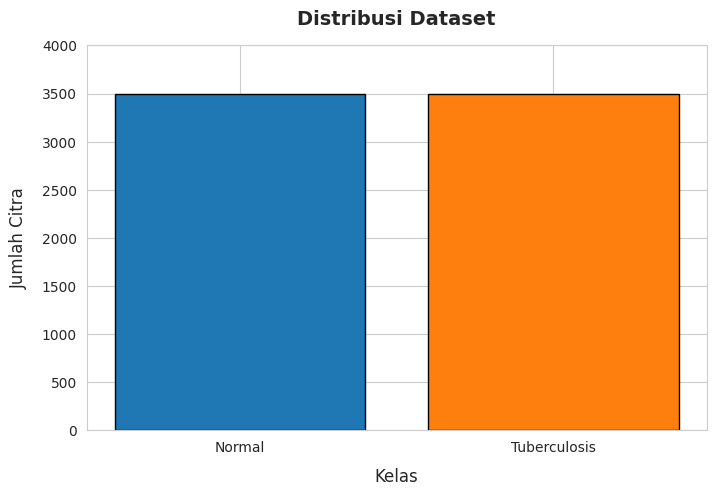

In [ ]:
# Distribusi Dataset
plt.figure(figsize=(8, 5))
plt.bar(['Normal', 'Tuberculosis'], [num_normal, num_tb],
        color=['#1f77b4', '#ff7f0e'], edgecolor='black')
plt.title('Distribusi Dataset', fontweight='bold', pad=15)
plt.xlabel('Kelas', labelpad=10)
plt.ylabel('Jumlah Citra', labelpad=10)
plt.ylim(0, 4000)
plt.show()

In [ ]:
# Preprocessing & Augmentasi
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet
])

dataset = datasets.ImageFolder(base_dir, transform=data_transforms)
classes = dataset.classes

In [ ]:
# Stratified Split dengan K-Fold
# Parameter
num_folds = 5
random_state = 42
test_size = 0.2

# Split awal (stratified)
labels = [y for _, y in dataset.samples]
train_val_idx, test_idx = train_test_split(
    range(len(dataset)),
    test_size=test_size,
    stratify=labels,
    random_state=random_state
)

# Subset untuk K-Fold
train_val_subset = Subset(dataset, train_val_idx)
test_subset = Subset(dataset, test_idx)

# Inisialisasi K-Fold
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_state)
train_val_labels = [labels[i] for i in train_val_idx]

# Verifikasi distribusi per fold
print("\nVerifikasi Distribusi Kelas per Fold:")
for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_subset, train_val_labels)):
    train_n = sum([train_val_labels[i] == 0 for i in train_idx])
    train_tb = sum([train_val_labels[i] == 1 for i in train_idx])
    val_n = sum([train_val_labels[i] == 0 for i in val_idx])
    val_tb = sum([train_val_labels[i] == 1 for i in val_idx])

    print(f"\nFold {fold+1}:")
    print(f"  Train - Normal: {train_n} | TB: {train_tb}")
    print(f"  Val   - Normal: {val_n} | TB: {val_tb}")


Verifikasi Distribusi Kelas per Fold:

Fold 1:
  Train - Normal: 2240 | TB: 2240
  Val   - Normal: 560 | TB: 560

Fold 2:
  Train - Normal: 2240 | TB: 2240
  Val   - Normal: 560 | TB: 560

Fold 3:
  Train - Normal: 2240 | TB: 2240
  Val   - Normal: 560 | TB: 560

Fold 4:
  Train - Normal: 2240 | TB: 2240
  Val   - Normal: 560 | TB: 560

Fold 5:
  Train - Normal: 2240 | TB: 2240
  Val   - Normal: 560 | TB: 560


In [ ]:
# Parameter
num_folds = 5
random_state = 42
test_size = 0.2

# Split awal (stratified)
labels = [y for _, y in dataset.samples]
train_val_idx, test_idx = train_test_split(
    range(len(dataset)),
    test_size=test_size,
    stratify=labels,
    random_state=random_state
)

# Subset untuk K-Fold
train_val_subset = Subset(dataset, train_val_idx)
test_subset = Subset(dataset, test_idx)

# Inisialisasi K-Fold
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_state)
train_val_labels = [labels[i] for i in train_val_idx]

In [ ]:
# Inisialisasi Model ResNet-18
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nMenggunakan device: {device}")

# Arsitektur model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(classes))
)
model = model.to(device)

# Summary model
print("\nModel Summary:")
from torchsummary import summary
summary(model, input_size=(3, 224, 224), device=device.type)


Menggunakan device: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 257MB/s]



Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14   

In [ ]:
# Training Loop dengan K-Fold Cross Validation
def train_fold(fold, train_idx, val_idx):
    # DataLoader
    train_loader = DataLoader(
        Subset(train_val_subset, train_idx),
        batch_size=32,
        shuffle=True,
        pin_memory=True
    )
    val_loader = DataLoader(
        Subset(train_val_subset, val_idx),
        batch_size=32,
        shuffle=False,
        pin_memory=True
    )

    # Inisialisasi model baru tiap fold
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, len(classes))
    )
    model = model.to(device)

    # Optimizer & scheduler
    optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.1)
    criterion = nn.CrossEntropyLoss()

    # Logging
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(25):
        # Training
        model.train()
        train_loss, train_correct = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        # Hitung metrik
        train_loss_epoch = train_loss / len(train_loader.dataset)
        train_acc_epoch = train_correct / len(train_loader.dataset)
        val_loss_epoch = val_loss / len(val_loader.dataset)
        val_acc_epoch = val_correct / len(val_loader.dataset)

        # Update history
        history['train_loss'].append(train_loss_epoch)
        history['train_acc'].append(train_acc_epoch)
        history['val_loss'].append(val_loss_epoch)
        history['val_acc'].append(val_acc_epoch)

        # Update scheduler
        scheduler.step(val_acc_epoch)

        # Save
        if val_acc_epoch > best_val_acc:
            best_val_acc = val_acc_epoch
            torch.save(model.state_dict(), f'best_model_fold{fold+1}.pth')

        print(f"Epoch {epoch+1}/25 | "
              f"Train Loss: {train_loss_epoch:.4f} | Train Acc: {train_acc_epoch:.4f} | "
              f"Val Loss: {val_loss_epoch:.4f} | Val Acc: {val_acc_epoch:.4f}")

    return history

In [ ]:
# Performa Training
def plot_training_history(history, fold):
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    # Plot accuracy
    ax[0].plot(history['train_acc'], label='Train Accuracy', color='#1f77b4', marker='o')
    ax[0].plot(history['val_acc'], label='Validation Accuracy', color='#ff7f0e', marker='o')
    ax[0].set_title(f'Fold {fold+1} - Accuracy', fontweight='bold')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Plot loss
    ax[1].plot(history['train_loss'], label='Train Loss', color='#2ca02c', marker='o')
    ax[1].plot(history['val_loss'], label='Validation Loss', color='#d62728', marker='o')
    ax[1].set_title(f'Fold {fold+1} - Loss', fontweight='bold')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
# Evaluasi Model
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy()[:,1])

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Print raw confusion matrix values
    print("\nRaw Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                annot_kws={'size': 14, 'color': 'black', 'weight': 'bold'},
                cbar=False)
    plt.title('Confusion Matrix', fontweight='bold', pad=15)
    plt.xlabel('Predicted Label', labelpad=12)
    plt.ylabel('True Label', labelpad=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Confusion Matriks
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.5, str(cm[i, j]),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white', fontsize=12)

    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = roc_auc_score(all_labels, all_probs)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='#1f77b4', lw=2,
             label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Receiver Operating Characteristic', fontweight='bold', pad=15)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    return all_labels, all_preds, all_probs

In [ ]:
# Implementasi Grad-CAM
def grad_cam(model, image_path):
    # Load dan preprocess gambar
    original_img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(original_img).unsqueeze(0).to(device)

    # Forward pass untuk prediksi
    model.eval()
    features, gradients = None, None

    def forward_hook(module, input, output):
        nonlocal features
        features = output.detach()

    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0].detach()

    # Hook ke layer4 ResNet-18
    handle_forward = model.layer4.register_forward_hook(forward_hook)
    handle_backward = model.layer4.register_backward_hook(backward_hook)

    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    confidence = torch.softmax(output, dim=1)[0][pred_class].item()

    # Hitung Grad-CAM
    output[:, pred_class].backward()
    weights = torch.mean(gradients, dim=[2, 3])
    cam = torch.sum(weights[:, :, None, None] * features, dim=1).squeeze()
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    cam = cam.cpu().numpy()
    cam = cv2.resize(cam, (224, 224))

    # 1.Original Image
    plt.figure(figsize=(6, 6))
    plt.imshow(original_img.resize((224, 224)), cmap='gray')
    plt.axis('off')
    plt.show()

    # 2. Overlay Heatmap + Confidence Score
    plt.figure(figsize=(6, 6))

    # Overlay heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlayed_img = cv2.addWeighted(np.array(original_img.resize((224, 224))), 0.5, heatmap, 0.5, 0)

    plt.imshow(overlayed_img)
    plt.title(f'Confidence: {confidence*100:.1f}%', fontsize=12, pad=10)
    plt.axis('off')
    plt.show()

    # Hapus hooks
    handle_forward.remove()
    handle_backward.remove()


Training Fold 1/5
Epoch 1/25 | Train Loss: 0.4196 | Train Acc: 0.8254 | Val Loss: 0.1630 | Val Acc: 0.9616
Epoch 2/25 | Train Loss: 0.1360 | Train Acc: 0.9585 | Val Loss: 0.0577 | Val Acc: 0.9893
Epoch 3/25 | Train Loss: 0.0816 | Train Acc: 0.9734 | Val Loss: 0.0349 | Val Acc: 0.9929
Epoch 4/25 | Train Loss: 0.0592 | Train Acc: 0.9812 | Val Loss: 0.0405 | Val Acc: 0.9875
Epoch 5/25 | Train Loss: 0.0398 | Train Acc: 0.9891 | Val Loss: 0.0180 | Val Acc: 0.9964
Epoch 6/25 | Train Loss: 0.0341 | Train Acc: 0.9895 | Val Loss: 0.0183 | Val Acc: 0.9946
Epoch 7/25 | Train Loss: 0.0288 | Train Acc: 0.9915 | Val Loss: 0.0202 | Val Acc: 0.9946
Epoch 8/25 | Train Loss: 0.0249 | Train Acc: 0.9926 | Val Loss: 0.0086 | Val Acc: 0.9982
Epoch 9/25 | Train Loss: 0.0225 | Train Acc: 0.9944 | Val Loss: 0.0118 | Val Acc: 0.9964
Epoch 10/25 | Train Loss: 0.0182 | Train Acc: 0.9940 | Val Loss: 0.0075 | Val Acc: 0.9982
Epoch 11/25 | Train Loss: 0.0157 | Train Acc: 0.9946 | Val Loss: 0.0067 | Val Acc: 0.9991


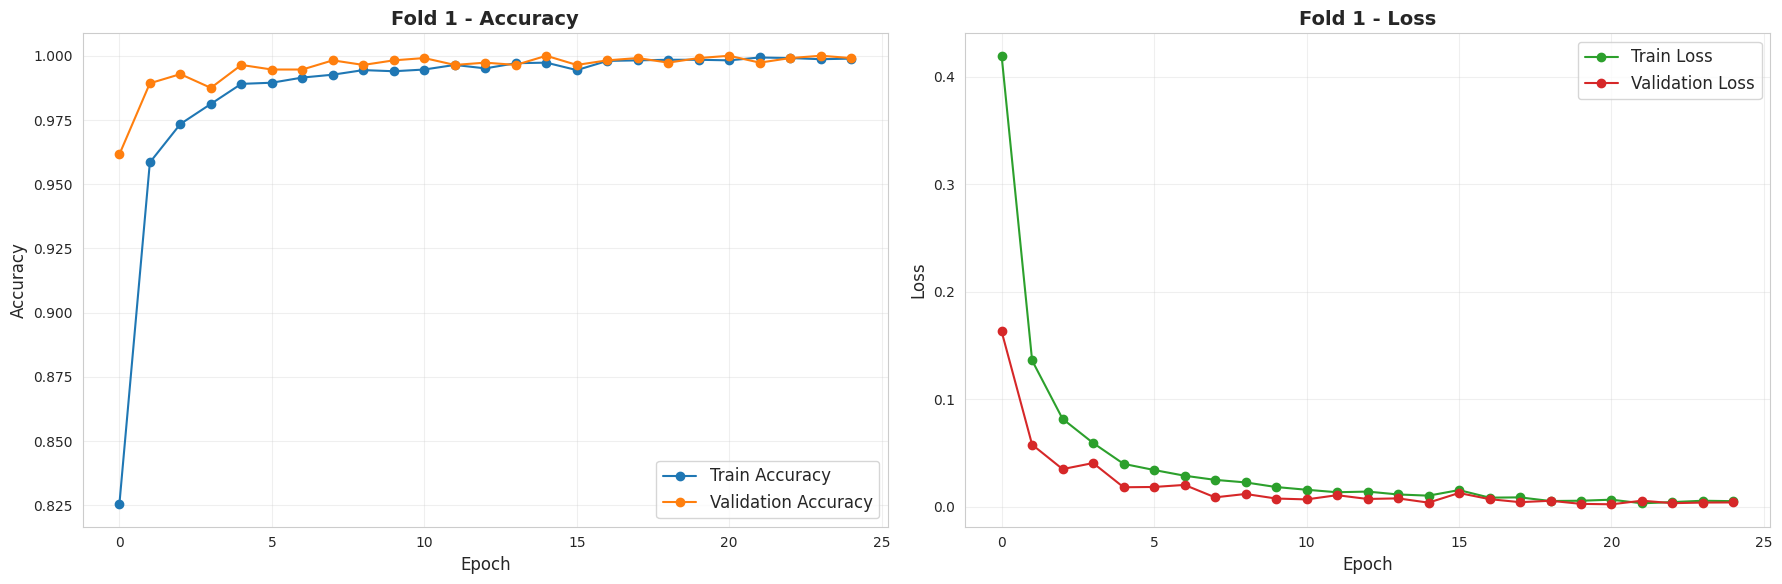


Training Fold 2/5
Epoch 1/25 | Train Loss: 0.4024 | Train Acc: 0.8420 | Val Loss: 0.1691 | Val Acc: 0.9554
Epoch 2/25 | Train Loss: 0.1353 | Train Acc: 0.9583 | Val Loss: 0.0639 | Val Acc: 0.9839
Epoch 3/25 | Train Loss: 0.0732 | Train Acc: 0.9768 | Val Loss: 0.0332 | Val Acc: 0.9955
Epoch 4/25 | Train Loss: 0.0539 | Train Acc: 0.9837 | Val Loss: 0.0209 | Val Acc: 0.9964
Epoch 5/25 | Train Loss: 0.0419 | Train Acc: 0.9875 | Val Loss: 0.0171 | Val Acc: 0.9973
Epoch 6/25 | Train Loss: 0.0264 | Train Acc: 0.9922 | Val Loss: 0.0222 | Val Acc: 0.9929
Epoch 7/25 | Train Loss: 0.0273 | Train Acc: 0.9900 | Val Loss: 0.0136 | Val Acc: 0.9946
Epoch 8/25 | Train Loss: 0.0221 | Train Acc: 0.9942 | Val Loss: 0.0102 | Val Acc: 0.9982
Epoch 9/25 | Train Loss: 0.0200 | Train Acc: 0.9942 | Val Loss: 0.0102 | Val Acc: 0.9964
Epoch 10/25 | Train Loss: 0.0177 | Train Acc: 0.9940 | Val Loss: 0.0098 | Val Acc: 0.9955
Epoch 11/25 | Train Loss: 0.0126 | Train Acc: 0.9964 | Val Loss: 0.0091 | Val Acc: 0.9973


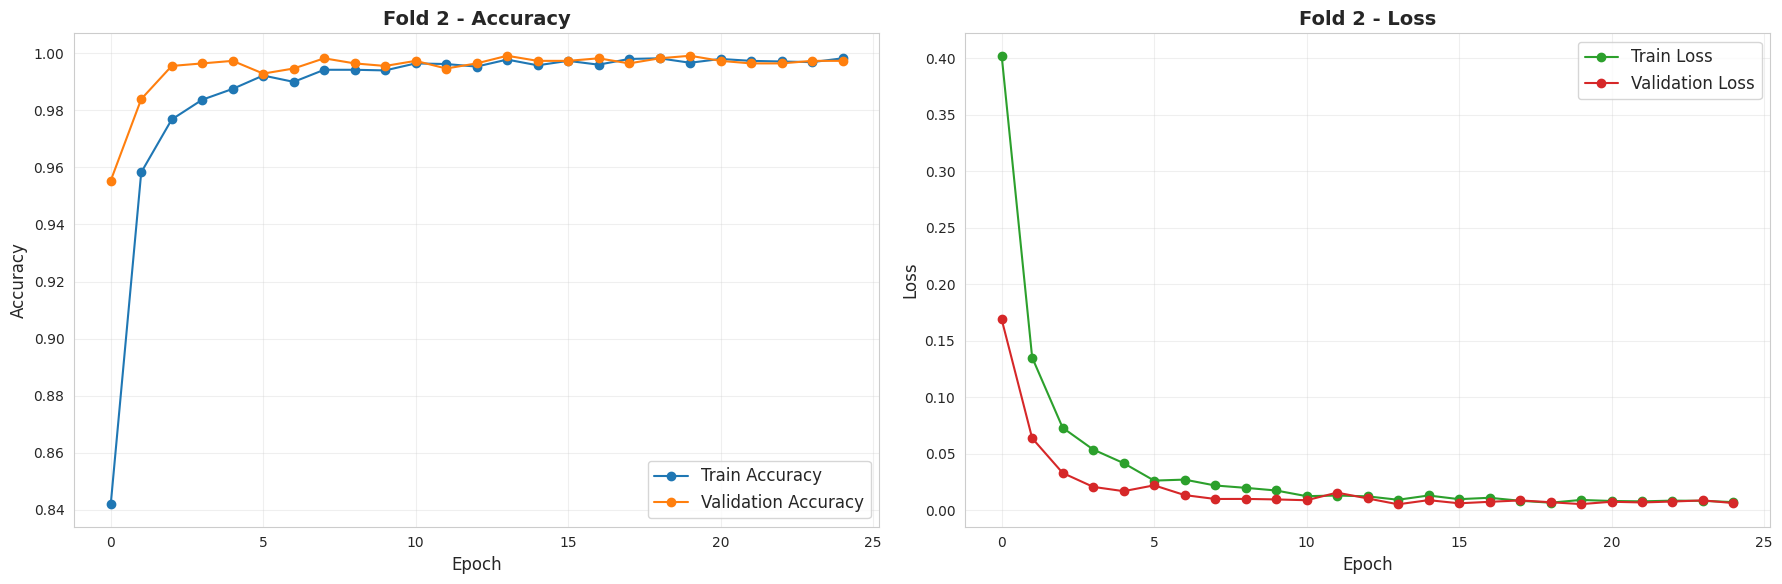


Training Fold 3/5
Epoch 1/25 | Train Loss: 0.4006 | Train Acc: 0.8525 | Val Loss: 0.1957 | Val Acc: 0.9321
Epoch 2/25 | Train Loss: 0.1380 | Train Acc: 0.9587 | Val Loss: 0.0890 | Val Acc: 0.9688
Epoch 3/25 | Train Loss: 0.0676 | Train Acc: 0.9797 | Val Loss: 0.0746 | Val Acc: 0.9768
Epoch 4/25 | Train Loss: 0.0503 | Train Acc: 0.9828 | Val Loss: 0.0420 | Val Acc: 0.9866
Epoch 5/25 | Train Loss: 0.0369 | Train Acc: 0.9895 | Val Loss: 0.0279 | Val Acc: 0.9938
Epoch 6/25 | Train Loss: 0.0291 | Train Acc: 0.9908 | Val Loss: 0.0201 | Val Acc: 0.9920
Epoch 7/25 | Train Loss: 0.0226 | Train Acc: 0.9938 | Val Loss: 0.0307 | Val Acc: 0.9875
Epoch 8/25 | Train Loss: 0.0224 | Train Acc: 0.9929 | Val Loss: 0.0277 | Val Acc: 0.9911
Epoch 9/25 | Train Loss: 0.0180 | Train Acc: 0.9944 | Val Loss: 0.0230 | Val Acc: 0.9920
Epoch 10/25 | Train Loss: 0.0178 | Train Acc: 0.9958 | Val Loss: 0.0143 | Val Acc: 0.9964
Epoch 11/25 | Train Loss: 0.0131 | Train Acc: 0.9967 | Val Loss: 0.0193 | Val Acc: 0.9946


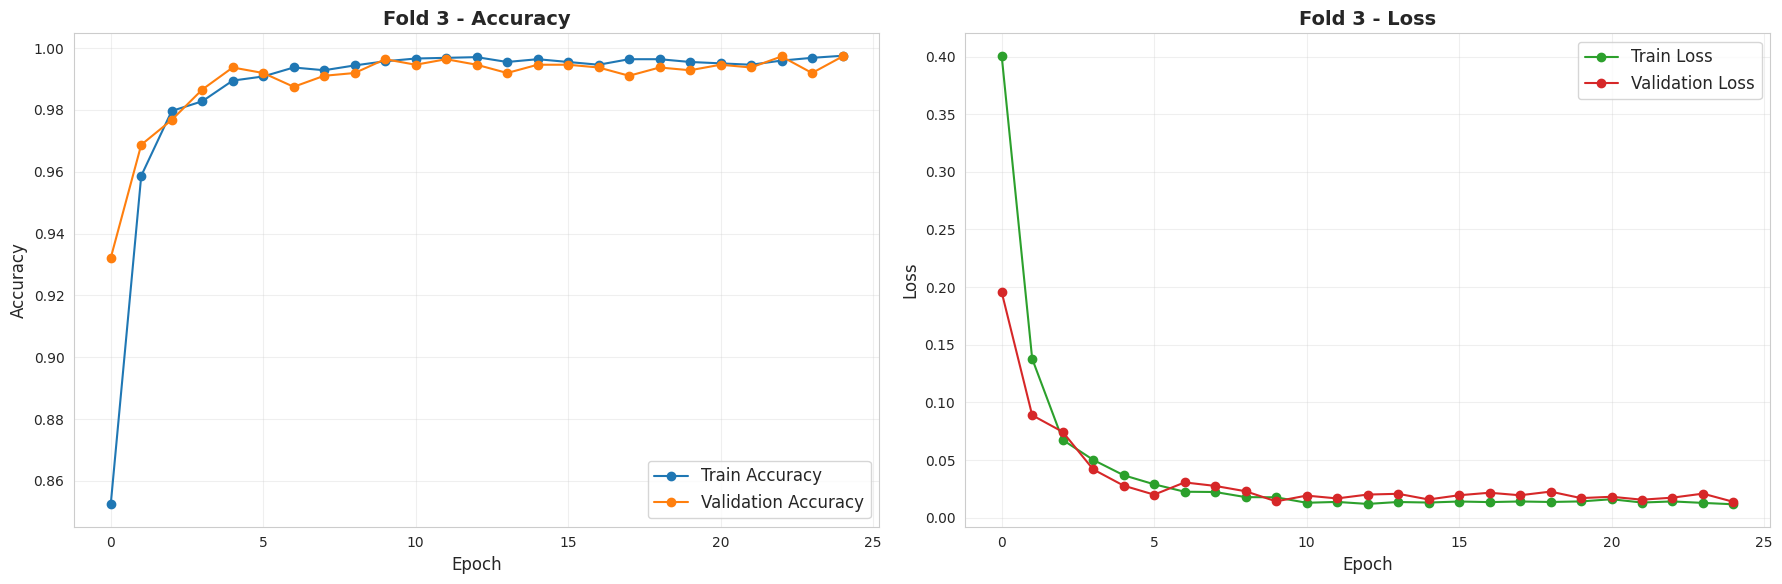


Training Fold 4/5
Epoch 1/25 | Train Loss: 0.4121 | Train Acc: 0.8335 | Val Loss: 0.1955 | Val Acc: 0.9286
Epoch 2/25 | Train Loss: 0.1338 | Train Acc: 0.9587 | Val Loss: 0.0745 | Val Acc: 0.9804
Epoch 3/25 | Train Loss: 0.0694 | Train Acc: 0.9808 | Val Loss: 0.0403 | Val Acc: 0.9920
Epoch 4/25 | Train Loss: 0.0484 | Train Acc: 0.9862 | Val Loss: 0.0307 | Val Acc: 0.9893
Epoch 5/25 | Train Loss: 0.0320 | Train Acc: 0.9911 | Val Loss: 0.0273 | Val Acc: 0.9866
Epoch 6/25 | Train Loss: 0.0275 | Train Acc: 0.9913 | Val Loss: 0.0311 | Val Acc: 0.9893
Epoch 7/25 | Train Loss: 0.0311 | Train Acc: 0.9886 | Val Loss: 0.0338 | Val Acc: 0.9875
Epoch 8/25 | Train Loss: 0.0222 | Train Acc: 0.9920 | Val Loss: 0.0272 | Val Acc: 0.9929
Epoch 9/25 | Train Loss: 0.0196 | Train Acc: 0.9949 | Val Loss: 0.0193 | Val Acc: 0.9955
Epoch 10/25 | Train Loss: 0.0206 | Train Acc: 0.9942 | Val Loss: 0.0178 | Val Acc: 0.9938
Epoch 11/25 | Train Loss: 0.0167 | Train Acc: 0.9958 | Val Loss: 0.0157 | Val Acc: 0.9946


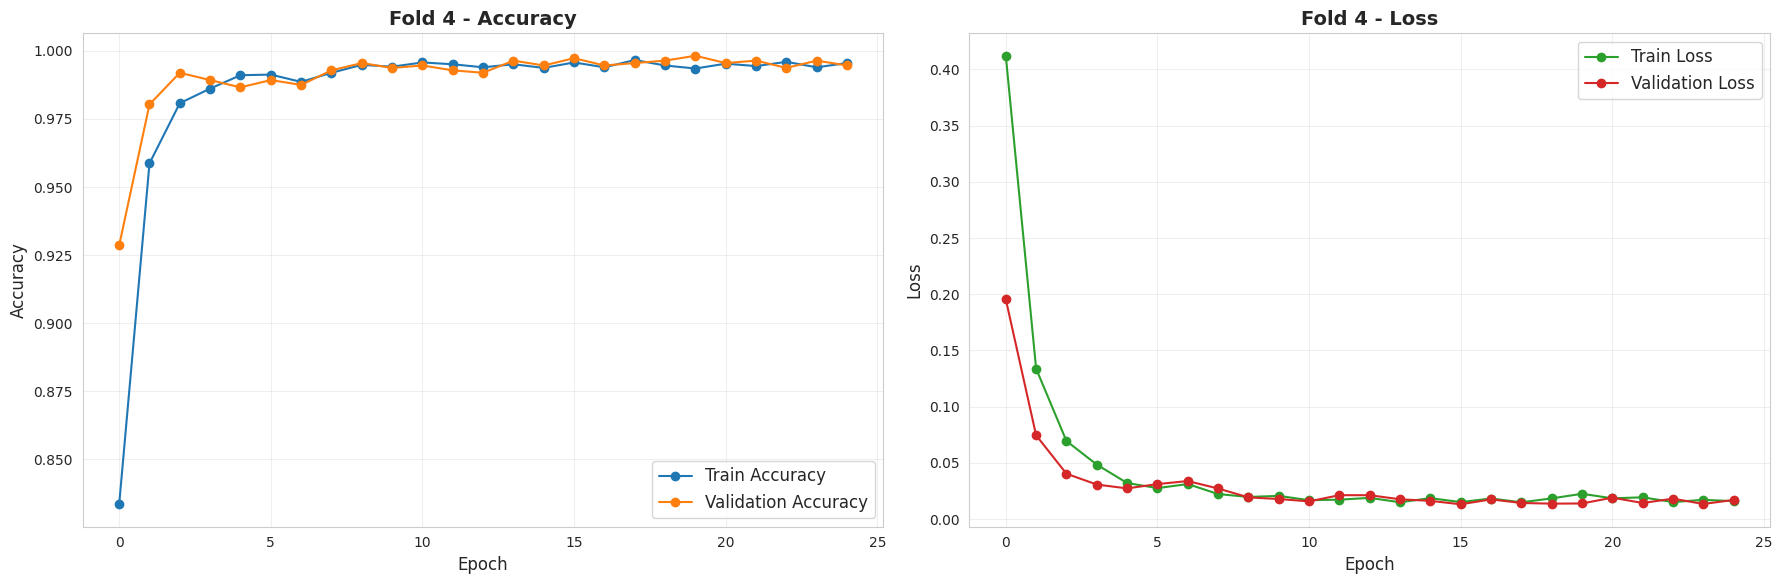


Training Fold 5/5
Epoch 1/25 | Train Loss: 0.4055 | Train Acc: 0.8382 | Val Loss: 0.2021 | Val Acc: 0.9348
Epoch 2/25 | Train Loss: 0.1479 | Train Acc: 0.9496 | Val Loss: 0.0806 | Val Acc: 0.9750
Epoch 3/25 | Train Loss: 0.0679 | Train Acc: 0.9812 | Val Loss: 0.0527 | Val Acc: 0.9839
Epoch 4/25 | Train Loss: 0.0518 | Train Acc: 0.9837 | Val Loss: 0.0494 | Val Acc: 0.9848
Epoch 5/25 | Train Loss: 0.0396 | Train Acc: 0.9848 | Val Loss: 0.0303 | Val Acc: 0.9902
Epoch 6/25 | Train Loss: 0.0363 | Train Acc: 0.9882 | Val Loss: 0.0174 | Val Acc: 0.9964
Epoch 7/25 | Train Loss: 0.0284 | Train Acc: 0.9884 | Val Loss: 0.0216 | Val Acc: 0.9938
Epoch 8/25 | Train Loss: 0.0213 | Train Acc: 0.9946 | Val Loss: 0.0250 | Val Acc: 0.9946
Epoch 9/25 | Train Loss: 0.0199 | Train Acc: 0.9951 | Val Loss: 0.0140 | Val Acc: 0.9955
Epoch 10/25 | Train Loss: 0.0176 | Train Acc: 0.9951 | Val Loss: 0.0136 | Val Acc: 0.9973
Epoch 11/25 | Train Loss: 0.0146 | Train Acc: 0.9958 | Val Loss: 0.0142 | Val Acc: 0.9964


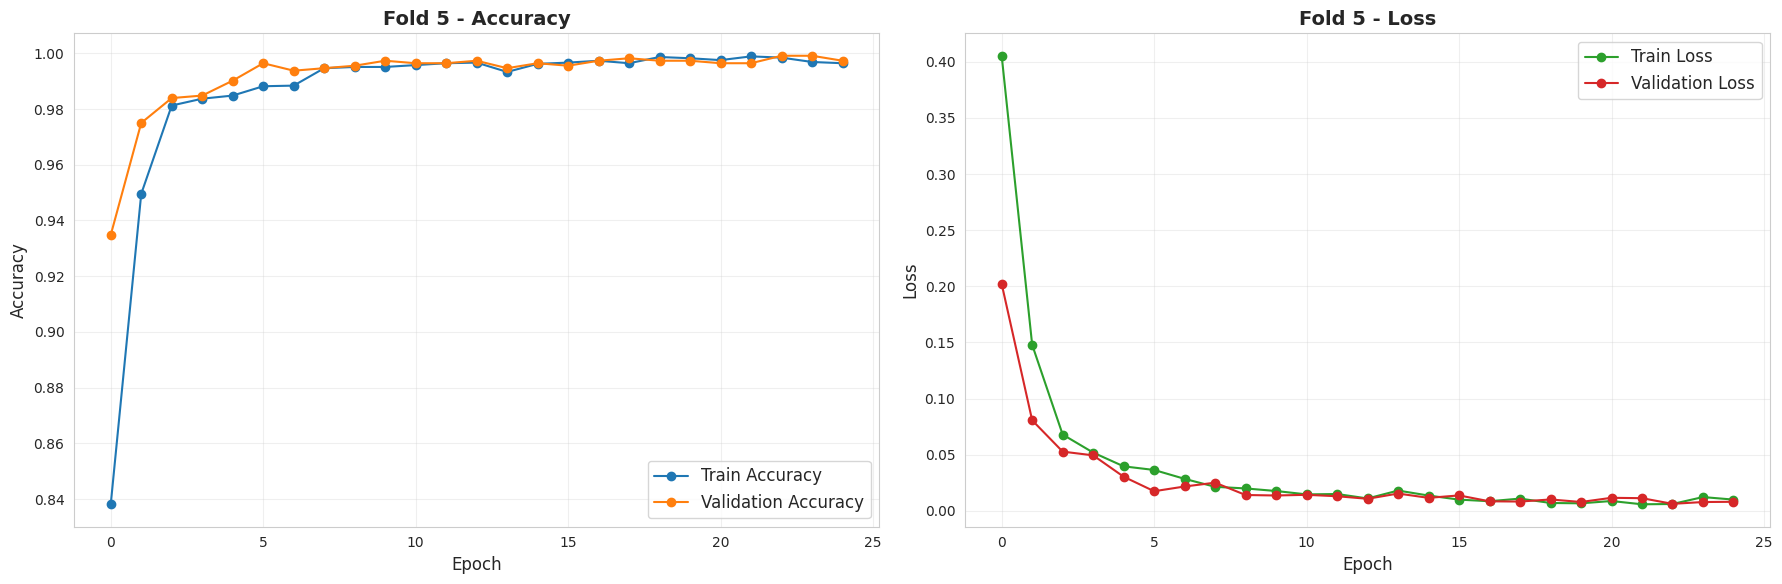


Best model: Fold 1

Distribusi Test Set:
Normal: 700, Tuberculosis: 700

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       700
Tuberculosis       1.00      0.99      1.00       700

    accuracy                           1.00      1400
   macro avg       1.00      1.00      1.00      1400
weighted avg       1.00      1.00      1.00      1400


Raw Confusion Matrix:
[[698   2]
 [  4 696]]


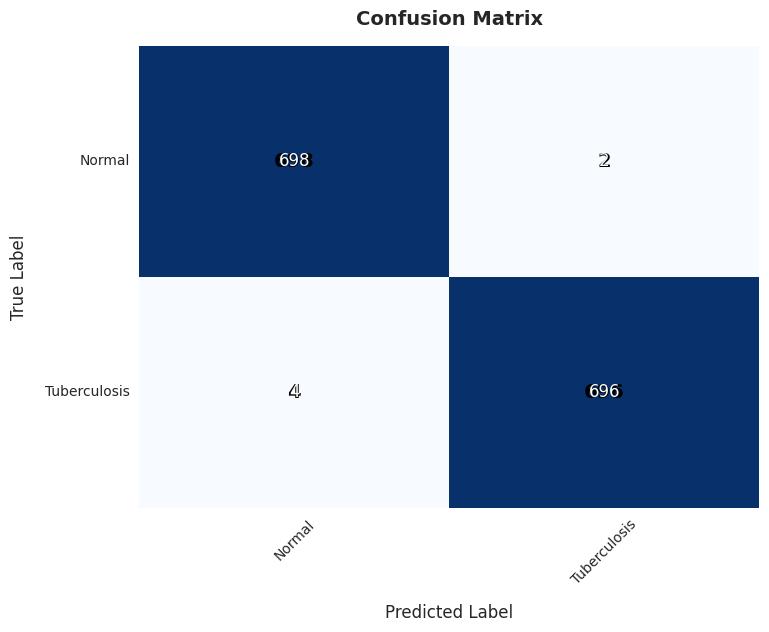

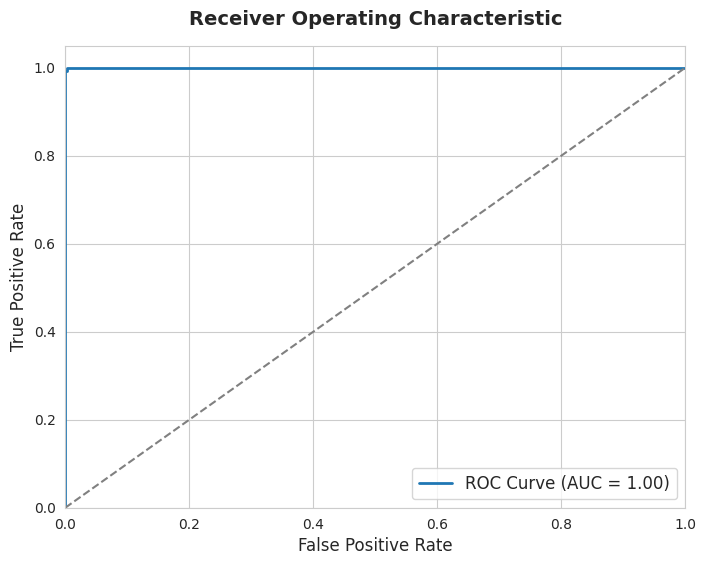


Contoh Grad-CAM untuk Normal:


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


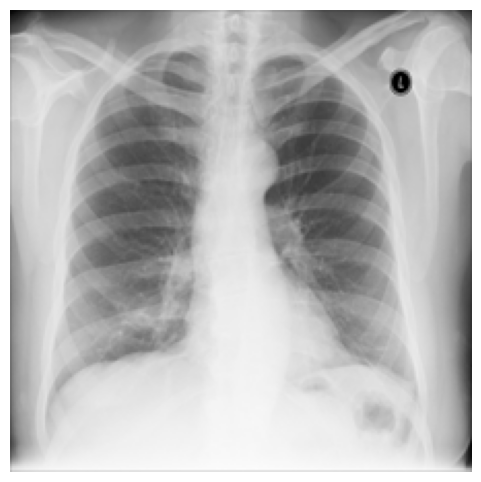

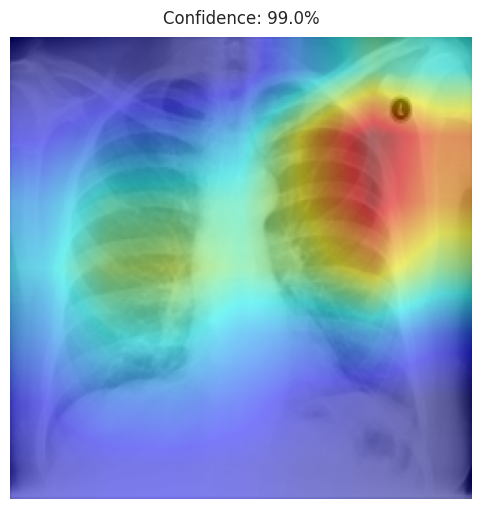


Contoh Grad-CAM untuk Tuberculosis:


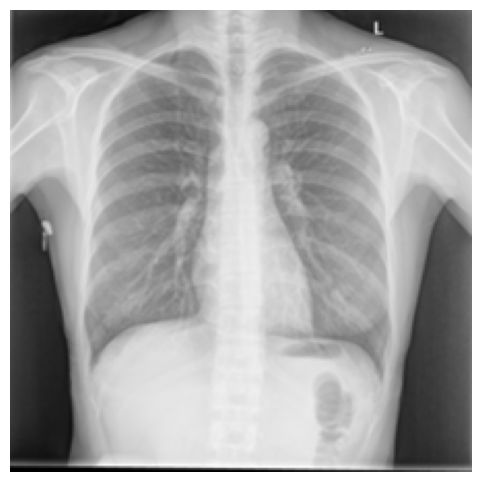

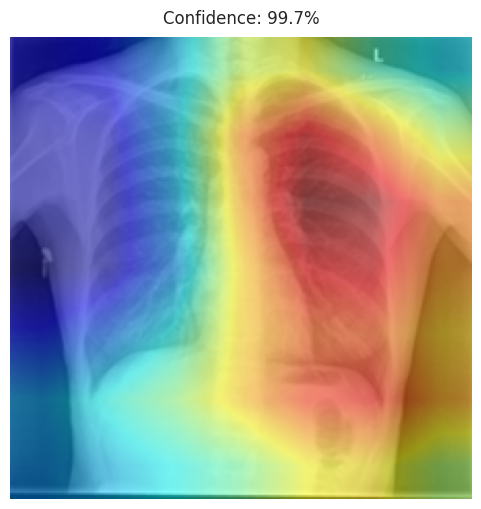

In [ ]:
if __name__ == "__main__":
    # Training seluruh fold
    all_histories = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_subset, train_val_labels)):
        print(f"\n{'='*40}")
        print(f"Training Fold {fold+1}/{num_folds}")
        print(f"{'='*40}")

        history = train_fold(fold, train_idx, val_idx)
        all_histories.append(history)
        plot_training_history(history, fold)

    # Evaluasi model terbaik
    best_fold = np.argmax([max(h['val_acc']) for h in all_histories])
    print(f"\nBest model: Fold {best_fold+1}")

    # Verifikasi distribusi kelas test set
    test_labels = [labels[i] for i in test_idx]
    print("\nDistribusi Test Set:")
    print(f"Normal: {test_labels.count(0)}, Tuberculosis: {test_labels.count(1)}")

    # Load model terbaik
    model.load_state_dict(torch.load(f'best_model_fold{best_fold+1}.pth'))
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

    # Evaluasi model
    true_labels, all_preds, all_probs = evaluate_model(model, test_loader)

    # Contoh Grad-CAM
    sample_normal = os.path.join(normal_dir, os.listdir(normal_dir)[0])
    sample_tb = os.path.join(tb_dir, os.listdir(tb_dir)[0])

    print("\nContoh Grad-CAM untuk Normal:")
    grad_cam(model, sample_normal)

    print("\nContoh Grad-CAM untuk Tuberculosis:")
    grad_cam(model, sample_tb)